In [44]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

inv = np.linalg.inv

In [65]:
filename = 'ios/rotation-through-g-field.csv'
filename = 'ios/rotation-along-principle-axes.csv'
t, _, _, _, ax, ay, az, _, gx, gy, gz, _, magx, magy, magz, _, _, alt, _  = pd.read_csv(filename).values.T

In [66]:
t = pd.to_datetime(t)

In [67]:
dt = ((t[-1] - t[0]) / (len(t) - 1)).value / 1e9

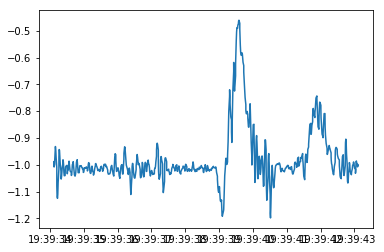

In [68]:
plt.plot(t, az)

In [69]:
def R_(yaw, pitch, roll):
    """http://planning.cs.uiuc.edu/node102.html"""
    """Performs first roll, then pitch, then yaw"""
    """a : alpha, yaw"""
    """b: beta, pitch"""
    """r: gamma, roll"""
    ca = np.cos(yaw)
    cb = np.cos(pitch)
    cg = np.cos(roll)
    sa = np.sin(yaw)
    sb = np.sin(pitch)
    sg = np.sin(roll)
    
    return np.array([
        [ca*cb, ca*sb*sg - sa*cg, ca*sb*cg + sa*sg],
        [sa*cb, sa*sb*sg + ca*cg, sa*sb*cg - ca*sg],
        [-sb, cb*sg, cb*cg]
    ])

def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    ix = R[0,0]
    iy = R[1,0]
    iz = R[2,0]
    jz = R[2,1]
    kz = R[2,2]
    
    roll = np.angle(1j*jz + kz)
    pitch = np.arcsin(-iz)
    yaw = np.arctan(iy/ix)
    
    return yaw, pitch, roll

In [70]:
ar = R_(0, np.pi / 180 * 15, -0.1) @ np.array([0, 0, -1])

In [71]:
ar

array([-0.25752603, -0.09983342, -0.96110022])

In [72]:
np.linalg.inv(R_(0, np.pi / 180 * 15, 0)) @ ar 

array([ 2.77555756e-17, -9.98334166e-02, -9.95004165e-01])

In [73]:
len(t)

899

In [74]:
np.vstack([ax, ay, az]).shape

(3, 899)

In [174]:
Q_acc = .01
Q_ang = 1

number_of_timesteps = len(t)
number_of_states = 2

Q = np.array([
    [Q_ang, 0],  
    [0, Q_ang],    
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([0, 0])
P = np.array([
    [Q_ang, 0],
    [0, Q_ang],
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        return mu
    
    def h(mu):
        pitch, roll = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0],
        [0, 1],
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = -(np.array([
        [cb*cg, -sb*sg],
        [0, -cg],
        [-sb*cg, -cb*sg]
    ]))

    # Predict
    mu_model = f(mu, _)
    P = F @ P @ F.T + Q

    # Update
    y = z - h(mu)
    K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model + K @ y
    P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

In [175]:
np.linalg.norm(z)

1.006489183990816

In [176]:
no_gyro_kalman_states = kalman_states.copy()

In [208]:
mu_model = np.array([np.pi, np.pi/2])

In [211]:
np.around(R_(0, np.pi/2, np.pi/2), 2)

array([[ 0.,  1.,  0.],
       [ 0.,  0., -1.],
       [-1.,  0.,  0.]])

In [215]:
np.around(R_(0, 0, 0), 2)


array([[ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [-0.,  0.,  1.]])

In [219]:
np.around(R_(0, np.pi/2, np.pi/2), 2)


array([[ 0.,  1.,  0.],
       [ 0.,  0., -1.],
       [-1.,  0.,  0.]])

In [220]:
np.around(R_(0, np.pi/2, 0)@ R_(0, 0, np.pi/2), 2)

array([[ 0.,  1.,  0.],
       [ 0.,  0., -1.],
       [-1.,  0.,  0.]])

In [209]:
h(mu_model)

array([-7.49879891e-33,  1.00000000e+00,  6.12323400e-17])

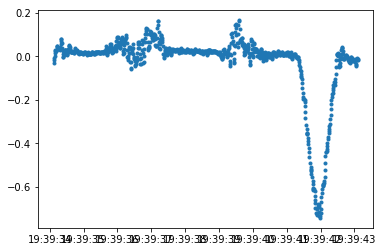

In [187]:
idx = 0
pitch = kalman_states[:, 0]
plt.plot(t, pitch, '.')

<ErrorbarContainer object of 3 artists>

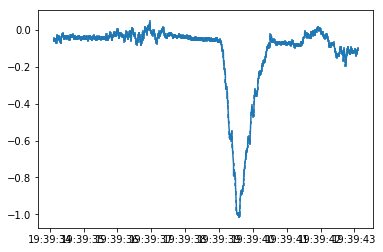

In [180]:
idx = 1
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])

In [82]:
Q_acc = .01
Q_ang = .0001 * dt

number_of_timesteps = len(t)
number_of_states = 3

Q = np.array([
    [Q_ang, 0, 0],  
    [0, Q_ang, 0],   
    [0, 0, Q_ang],   
])    

R = np.array([
    [Q_acc, 0, 0],
    [0, Q_acc, 0],    
    [0, 0, Q_acc]
]) ** 2    

kalman_states = np.empty((number_of_timesteps, number_of_states)) * np.nan
kalman_errors = np.empty((number_of_timesteps, number_of_states)) * np.nan

I = np.identity(number_of_states)

# initialize state
mu = np.array([0, 0, 0])
P = np.array([
    [Q_ang, 0, 0],
    [0, Q_ang, 0],
    [0, 0, Q_ang],    
])
for time_index in range(number_of_timesteps):
    # Kalman step

    pitch, roll, yaw = mu     
    ax_, ay_, az_ = np.stack([ax, ay, az]).T[time_index, :]
    
    def f(mu, u):
        gx, gy, gz = u
        dyaw = gz * dt
        dpitch = gx * dt
        droll = gy * dt
        
        pitch, roll, yaw = mu
        
        total_R = R_(dyaw, dpitch, droll) @ R_(yaw, pitch, roll)
        yaw, pitch, roll = get_yaw_pitch_roll_from_R(total_R)
        mu = np.array([pitch, roll, yaw])
        
        return mu
    
    def h(mu):
        pitch, roll, yaw = mu
        return R_(0, pitch, roll) @ np.array([0, 0, -1])

    F = np.array([
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]
    ])    
    
    z = np.array([ax_, ay_, az_])
    
    cb = np.cos(pitch)
    sb = np.sin(pitch)
    cg = np.cos(roll)
    sg = np.sin(roll)
    
    H = - np.array([
        [cb*cg, -sb*sg, 0],
        [0, -cg, 0],
        [-sb*cg, -cb*sg, 0]
    ])

    # Predict
    u = np.vstack([gx, gy, gz]).T[time_index]
    mu_model = f(mu, u)
    P = F @ P @ F.T + Q

    # Update
    #y = z - h(mu)
    #K = P @ H.T @ np.linalg.inv(R + H @ P @ H.T)
    mu = mu_model #+ K @ y
    #P = (I - K @ H) @ P @ (I - K @ H).T + K @ R @ K.T
    #y = z - H @ mu # post-fit residual

    kalman_states[time_index,:] = mu
    kalman_errors[time_index,:] = P.diagonal()**.5

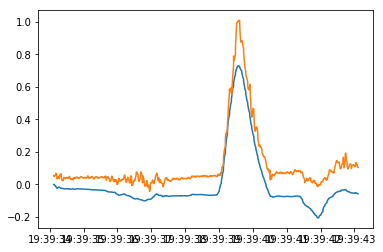

In [83]:
fig, axis = plt.subplots(1)
idx = 0
#ax.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
axis.plot(t, kalman_states[:, idx])
idx = 1
axis.plot(t, -no_gyro_kalman_states[:, idx])

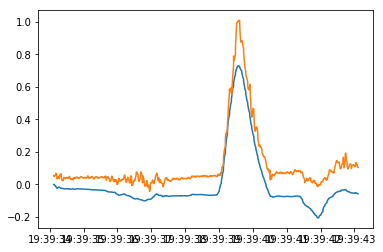

In [84]:
fig, axis = plt.subplots(1)
idx = 0
#ax.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])
axis.plot(t, kalman_states[:, idx])
idx = 1
axis.plot(t, -no_gyro_kalman_states[:, idx])

<ErrorbarContainer object of 3 artists>

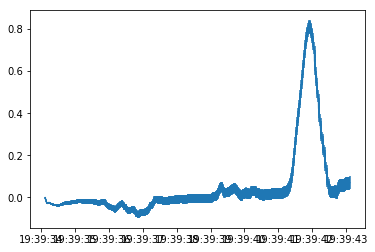

In [85]:
idx = 1
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])

<ErrorbarContainer object of 3 artists>

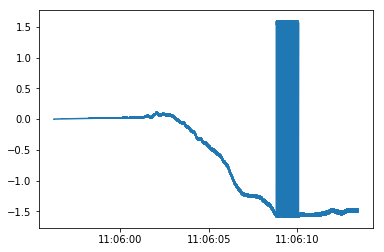

In [150]:
idx = 2
plt.errorbar(t, kalman_states[:, idx], kalman_errors[:, idx])

In [151]:
np.vstack([gx, gy, gz]).T[3]#.shape

array([-0.01688896864652634, 0.007861651480197906, -0.007253119256347419],
      dtype=object)

In [ ]:
yaw_component = cos_pitch * cos_roll


In [44]:
np.array([
    [11,12,13],
    [21, 22, 23],
    [31, 32,33]
])[0,2]

13

In [56]:
def get_yaw_pitch_roll_from_R(R):
    """https://math.stackexchange.com/a/2802520"""
    ix = R[0,0]
    iy = R[1,0]
    iz = R[2,0]
    jz = R[2,1]
    kz = R[2,2]
    
    roll = np.angle(1j*jz + kz)
    pitch = np.arcsin(-iz)
    yaw = np.arctan(iy/ix)
    
    return yaw, pitch, roll

In [58]:
get_yaw_pitch_roll_from_R(R_(1, 0.5, .7))

(1.0, 0.5, 0.7)